# **COVID-19 Chest X-Ray Classification**

# **Summary**
This notebook presents a deep learning project focused on multi-class classification of chest X-ray images to detect COVID-19, Viral Pneumonia, and normal lung conditions. It uses a transfer learning approach with the pre-trained VGG16 model alongside a custom-built Convolutional Neural Network (CNN). To improve generalization, data augmentation and class weighting techniques are applied during training. Evaluation shows strong results, with the VGG16 model achieving 94% accuracy and recall, and the custom CNN achieving 92% accuracy and 82% recall. The project also employs Grad-CAM visualizations to provide interpretability by highlighting the image regions that influence the model’s predictions.

## **Prerequisites**

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import cv2

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import backend

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.applications.vgg16 import preprocess_input
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore


SEED = 42
np.random.seed(SEED)
random.seed(SEED)

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the image file of dataset
images = np.load('CovidImages.npy')

# Load the labels file of dataset
labels = pd.read_csv('CovidLabels.csv')

## **Data Overview**



In [7]:
print(images.shape)

print(labels.shape)

(251, 128, 128, 3)
(251, 1)


In [4]:
labels.isna().sum()

,0
Label,0


In [4]:
labels['Label'] = labels['Label'].str.strip()

In [6]:
unique_classes = labels['Label'].unique()
print("Classes:", unique_classes)

Classes: ['Viral Pneumonia' 'Covid' 'Normal']


## **Exploratory Data Analysis**

In [7]:
def plot_images(images, labels, class_names):
    rows, cols = 3, 4
    fig = plt.figure(figsize=(12, 9))

    for i in range(rows * cols):
        idx = np.random.randint(len(images))
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.imshow(images[idx], cmap='gray')
        ax.set_title(labels[idx])
        ax.axis('off')

    plt.tight_layout()
    plt.show()

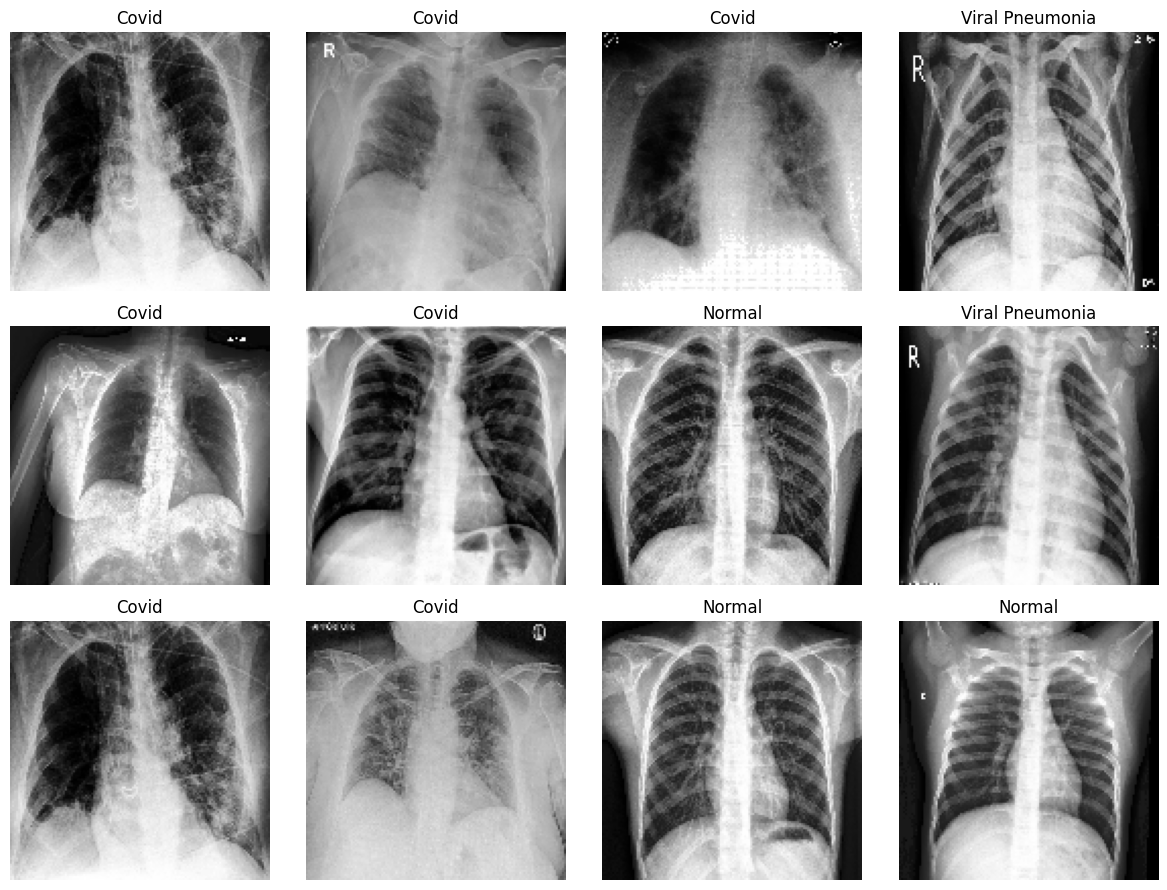

In [8]:
plot_images(images, labels['Label'].values, unique_classes)

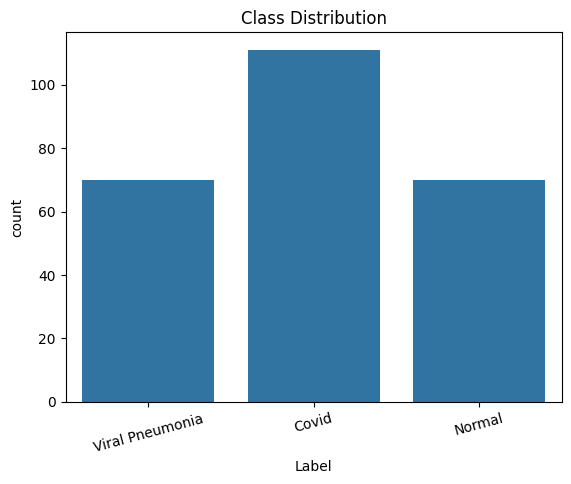

In [9]:
# Check class imbalance
sns.countplot(x=labels['Label'])
plt.title("Class Distribution")
plt.xticks(rotation=15)
plt.show()

In [10]:
# Count number of cases in each class
class_counts = labels['Label'].value_counts()
print("Class Distribution:\n", class_counts)

Class Distribution:
 Label
Covid              111
Viral Pneumonia     70
Normal              70
Name: count, dtype: int64


## **Preprocessing**

In [3]:
# Label Encoding
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels['Label'])

In [4]:
# One-Hot Encoding
labels_one_hot = to_categorical(labels_encoded, num_classes=3)

In [5]:
# Resize images

def preprocess_images(img_array, size=128):
    processed_images = []
    for img in img_array:
        resized = cv2.resize(img, (size, size))
        processed_images.append(resized)
    return np.array(processed_images).astype('float32') / 255.0


images_preprocessed = preprocess_images(images, size=128)
print("Final shape:", images_preprocessed.shape)


Final shape: (251, 128, 128, 3)


In [6]:
X_train, X_test, y_train_one_hot, y_test_one_hot, y_train_encoded, y_test_encoded = train_test_split(
    images_preprocessed,
    labels_one_hot,
    labels_encoded,
    test_size=0.2,
    stratify=labels_encoded,
    random_state=42
)

In [7]:
class_weight_values = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_encoded),
    y=y_train_encoded
)
class_weight_dict = dict(enumerate(class_weight_values))

In [8]:
print("X_train shape:", X_train.shape)
print("y_train_one_hot shape:", y_train_one_hot.shape)
print("class weights:", class_weight_dict)

X_train shape: (200, 128, 128, 3)
y_train_one_hot shape: (200, 3)
class weights: {0: np.float64(0.7575757575757576), 1: np.float64(1.1904761904761905), 2: np.float64(1.1904761904761905)}


## **Model Building - Convolutional Neural Network (CNN)**

### Model1

In [65]:
# Clearing backend
backend.clear_session()

In [66]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Intializing a sequential model
model1 = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of images
model1.add(Conv2D(16, (3, 3), activation = 'relu', padding = "same", input_shape = (128, 128, 3)))

# Adding max pooling to reduce the size of output of first conv layer
model1.add(MaxPooling2D((2, 2), padding = 'same'))

model1.add(Conv2D(32, (3, 3), activation = 'relu', padding = "same"))
model1.add(MaxPooling2D((2, 2), padding = 'same'))

model1.add(Conv2D(64, (3, 3), activation = 'relu', padding = "same"))
model1.add(MaxPooling2D((2, 2), padding = 'same'))


# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model1.add(Flatten())

# Adding a fully connected dense layer with 100 neurons
model1.add(Dense(8, activation = 'relu'))
model1.add(Dropout(0.3))

# Adding the output layer with 3 neurons and activation functions as softmax since this is a multi-class classification problem
model1.add(Dense(3, activation = 'softmax'))

opt=Adam()

# Compile model
model1.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy', Recall()])

# Generating the summary of the model
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │       131,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 154,691 (604.26 KB)

 Trainable params: 154,691 (604.26 KB)

 Non-trainable params: 0 (0.00 B)

In [67]:
history_1 = model1.fit(
    datagen.flow(X_train, y_train_one_hot, batch_size=32, subset='training'),
    validation_data=datagen.flow(X_train, y_train_one_hot, batch_size=32, subset='validation'),
    epochs=15,
    shuffle=True,
    class_weight=class_weight_dict,
)

Epoch 1/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 461ms/step - accuracy: 0.3344 - loss: 1.1046 - recall: 0.0411 - val_accuracy: 0.1750 - val_loss: 1.1553 - val_recall: 0.0000e+00
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 372ms/step - accuracy: 0.2942 - loss: 1.0877 - recall: 0.0634 - val_accuracy: 0.2750 - val_loss: 1.0958 - val_recall: 0.0000e+00
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 363ms/step - accuracy: 0.3143 - loss: 1.0775 - recall: 0.0291 - val_accuracy: 0.1500 - val_loss: 1.1229 - val_recall: 0.0500
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 361ms/step - accuracy: 0.3970 - loss: 1.0212 - recall: 0.1491 - val_accuracy: 0.3750 - val_loss: 1.0382 - val_recall: 0.1000
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 513ms/step - accuracy: 0.4599 - loss: 0.9886 - recall: 0.1878 - val_accuracy: 0.4000 - val_loss: 1.0140 - val_recall: 0.2000
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 361ms/step - accuracy: 0.5286 - loss: 0.9826 - recall: 0.2403 - val_accuracy: 0.7500 - val_loss: 1.0500 - val_recall: 0.0500
Epoch 7/

#### **Model Evaluation**

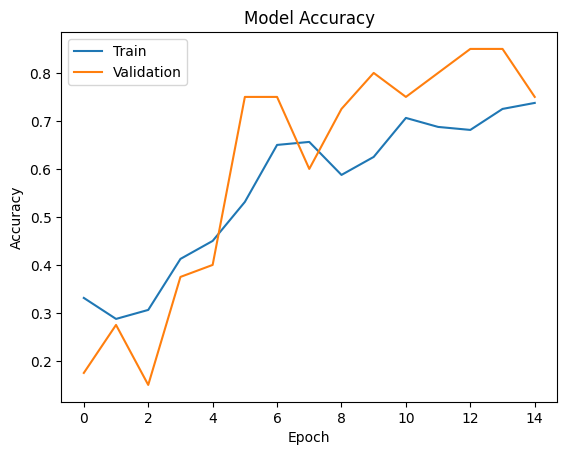

In [68]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.show()

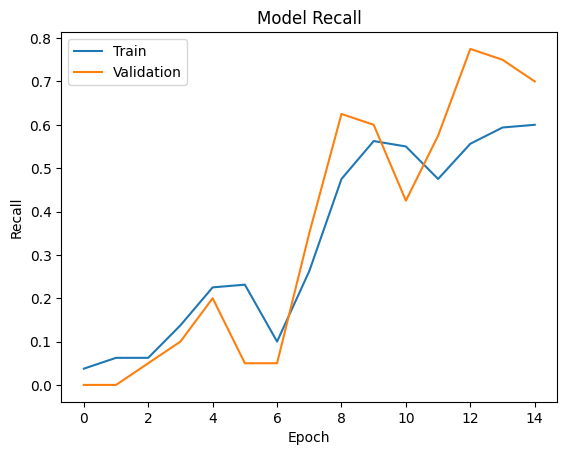

In [70]:
plt.plot(history_1.history['recall'])
plt.plot(history_1.history['val_recall'])
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.show()

#### **Evaluating the model on test data**

In [72]:
accuracy = model1.evaluate(X_test, y_test_one_hot, verbose = 2)

2/2 - 1s - 441ms/step - accuracy: 0.7255 - loss: 0.5537 - recall: 0.6667


#### **Plotting the Confusion Matrix**




In [74]:
# Getting the output as probablities for each category
y_pred = model1.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step


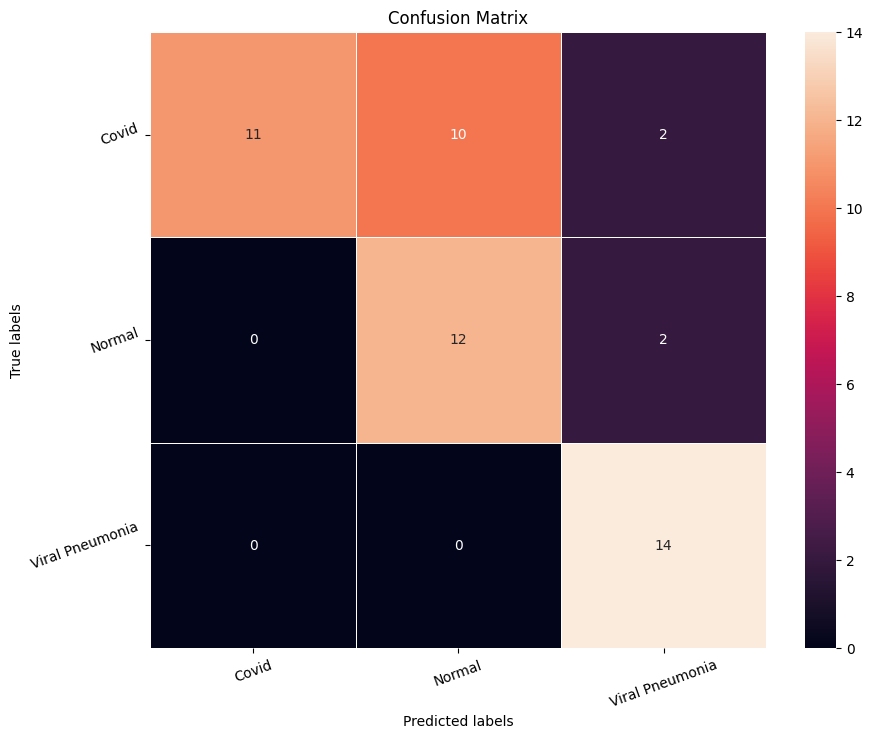

In [75]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg = np.argmax(y_pred, axis = 1)
y_test_arg = np.argmax(y_test_one_hot, axis = 1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined in tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg, y_pred_arg)
f, ax = plt.subplots(figsize = (10, 8))
sns.heatmap(
    confusion_matrix,
    annot = True,
    linewidths = .4,
    fmt = "d",
    square = True,
    ax = ax
)
# Setting the labels to both the axes
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Covid', 'Normal', 'Viral Pneumonia'], rotation = 20)
ax.yaxis.set_ticklabels(['Covid', 'Normal', 'Viral Pneumonia'], rotation = 20)
plt.show()

**Performance:**

- Accuracy on test data: 72.55%
- Loss: 0.5337
- Recall: 66.67%
- Class-specific performance:

- COVID Cases: All 11 were correctly classified (perfect recall for COVID class).
- Normal Cases: Out of 22 normal cases, 10 were misclassified as COVID, resulting in a lower precision for this class.
- Pneumonia Cases: Out of 20 pneumonia cases, 4 was misclassified.

<b> Deleting the model and history variable to use the RAM efficiently

In [76]:
del model1
del history_1

### Model 2

In [77]:
backend.clear_session()

In [80]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Initializing model2
model2 = Sequential()

# Conv Block 1
model2.add(Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 3)))
model2.add(MaxPooling2D((2, 2), padding='same'))

# Conv Block 2
model2.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model2.add(MaxPooling2D((2, 2), padding='same'))

# Conv Block 3
model2.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model2.add(MaxPooling2D((2, 2), padding='same'))

# Conv Block 4 (NEW)
model2.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model2.add(MaxPooling2D((2, 2), padding='same'))

# Flatten + Dense
model2.add(Flatten())
model2.add(Dense(64, activation='relu'))
model2.add(Dropout(0.3))

# Output layer
model2.add(Dense(3, activation='softmax'))

# Compile
opt = Adam(learning_rate=0.001)
model2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy', Recall()])

lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)


# Summary
model2.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       262,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 322,915 (1.23 MB)

 Trainable params: 322,915 (1.23 MB)

 Non-trainable params: 0 (0.00 B)

In [82]:
history_2 = model2.fit(
    datagen.flow(X_train, y_train_one_hot, batch_size=32, subset='training'),
    validation_data=datagen.flow(X_train, y_train_one_hot, batch_size=32, subset='validation'),
    epochs=20,
    shuffle=True,
    class_weight=class_weight_dict,
    callbacks=[lr_schedule]  # Implement learning rate schedule
)

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 410ms/step - accuracy: 0.3249 - loss: 1.0947 - recall_1: 0.0000e+00 - val_accuracy: 0.2750 - val_loss: 1.0986 - val_recall_1: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 381ms/step - accuracy: 0.4209 - loss: 1.0429 - recall_1: 0.0201 - val_accuracy: 0.6500 - val_loss: 0.8358 - val_recall_1: 0.4500 - learning_rate: 0.0010
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 385ms/step - accuracy: 0.4926 - loss: 0.9927 - recall_1: 0.1328 - val_accuracy: 0.7500 - val_loss: 0.6269 - val_recall_1: 0.6000 - learning_rate: 0.0010
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 384ms/step - accuracy: 0.6444 - loss: 0.8548 - recall_1: 0.4213 - val_accuracy: 0.6750 - val_loss: 0.9356 - val_recall_1: 0.5250 - learning_rate: 0.0010
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 549ms/step - accuracy: 0.6260 - loss: 0.7790 - recall_1: 0.4835 - val_accuracy: 0.8500 - val_loss: 0.5089 - val_recall_1: 0.7250 - learning_rate: 0.0010
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━

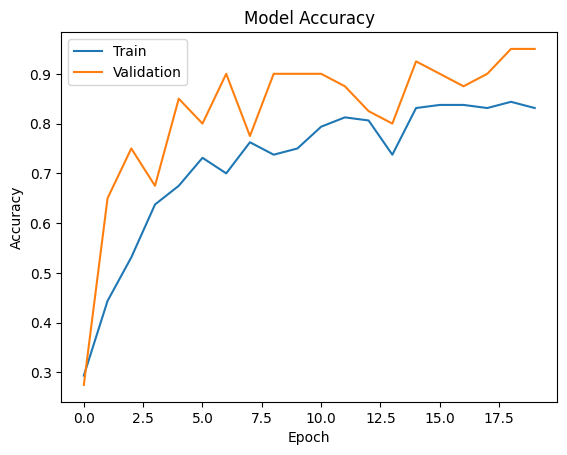

In [83]:
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.show()

In [85]:
accuracy = model2.evaluate(X_test, y_test_one_hot, verbose = 2)

2/2 - 1s - 341ms/step - accuracy: 0.8824 - loss: 0.2701 - recall_1: 0.8627


In [86]:
y_pred = model2.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


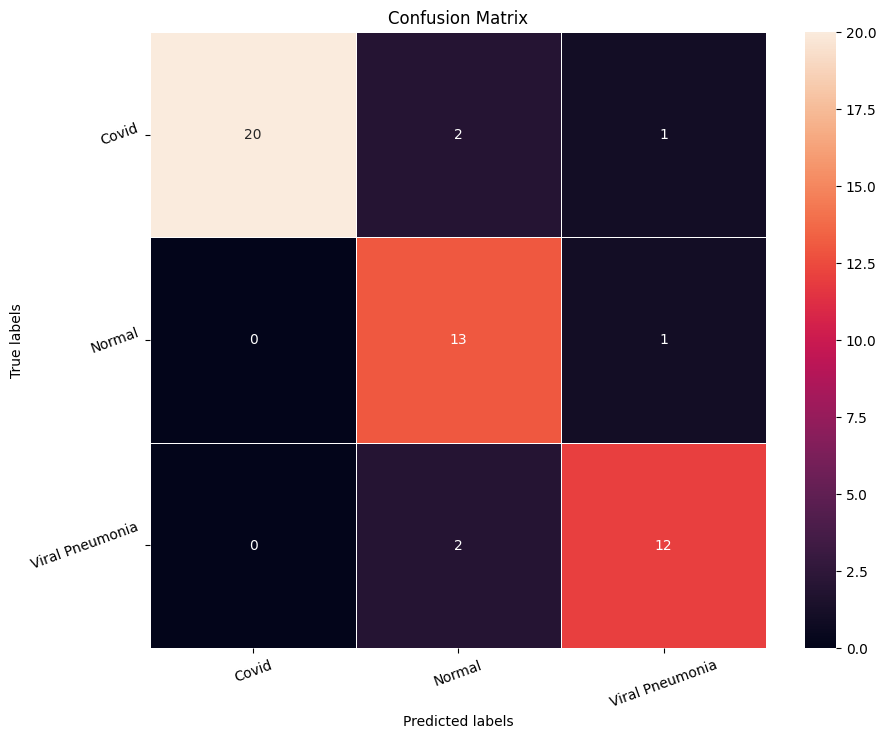

In [87]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg = np.argmax(y_pred, axis = 1)
y_test_arg = np.argmax(y_test_one_hot,axis = 1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg, y_pred_arg)

f, ax = plt.subplots(figsize = (10, 8))

sns.heatmap(
    confusion_matrix,
    annot = True,
    linewidths = .4,
    fmt = "d",
    square = True,
    ax = ax
)

# Setting the labels to both the axes
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Covid', 'Normal', 'Viral Pneumonia'], rotation = 20)
ax.yaxis.set_ticklabels(['Covid', 'Normal', 'Viral Pneumonia'], rotation = 20)
plt.show()

**Performance:**

- Accuracy on test data: 88.24%
- Loss: 0.2701
- Recall: 86.27%
- Class-specific performance:

- COVID Cases:All cases were classified correctly.
- Normal Cases: 13 cases were correctly classified and 4 were misclassified.
- Pneumonia Cases: Out of 14 pneumonia cases, 2 was misclassified.

In [90]:
del model2
del history_2

### Model 3

In [91]:
backend.clear_session()

In [92]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Initializing a sequential model
model3 = Sequential()

model3.add(Conv2D(8, (3, 3), activation='relu', padding="same", input_shape=(128, 128, 3)))
model3.add(MaxPooling2D((2, 2), padding='same'))

model3.add(Conv2D(16, (3, 3), activation='relu', padding="same"))
model3.add(MaxPooling2D((2, 2), padding='same'))

model3.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model3.add(MaxPooling2D((2, 2), padding='same'))

model3.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model3.add(MaxPooling2D((2, 2), padding='same'))

model3.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model3.add(MaxPooling2D((2, 2), padding='same'))


# Flattening the output
model3.add(Flatten())

# Fully connected dense layer with more neurons
model3.add(Dense(16, activation='relu'))
model3.add(Dropout(0.4))  # Increased dropout for better regularization

# Output layer for 3-class classification
model3.add(Dense(3, activation='softmax'))

# Compile the model
opt = Adam(learning_rate=0.001)
model3.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy', Recall()])

# Generate the summary of the improved model
model3.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │        16,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,907 (304.32 KB)

 Trainable params: 77,907 (304.32 KB)

 Non-trainable params: 0 (0.00 B)

In [93]:
history_3 = model3.fit(
    datagen.flow(X_train, y_train_one_hot, batch_size=32, subset='training'),
    validation_data=datagen.flow(X_train, y_train_one_hot, batch_size=32, subset='validation'),
    epochs=25,
    shuffle=True,
    class_weight=class_weight_dict,
)

Epoch 1/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 410ms/step - accuracy: 0.2645 - loss: 1.1414 - recall: 0.0000e+00 - val_accuracy: 0.6750 - val_loss: 1.0701 - val_recall: 0.0000e+00
Epoch 2/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step - accuracy: 0.4620 - loss: 1.0947 - recall: 0.0000e+00 - val_accuracy: 0.5750 - val_loss: 1.0718 - val_recall: 0.0000e+00
Epoch 3/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step - accuracy: 0.3521 - loss: 1.0952 - recall: 0.0000e+00 - val_accuracy: 0.3500 - val_loss: 1.0606 - val_recall: 0.0000e+00
Epoch 4/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 269ms/step - accuracy: 0.4493 - loss: 1.0401 - recall: 0.0608 - val_accuracy: 0.3500 - val_loss: 1.0281 - val_recall: 0.1000
Epoch 5/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step - accuracy: 0.4151 - loss: 1.0074 - recall: 0.1201 - val_accuracy: 0.7500 - val_loss: 0.9267 - val_recall: 0.0250
Epoch 6/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 269ms/step - accuracy: 0.6103 - loss: 0.9292 - recall: 0.2564 - val_accuracy: 0.8000 - val_loss: 0.7226 - val_recall:

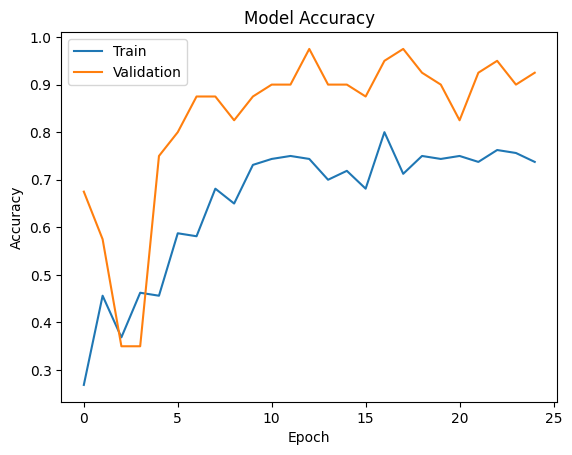

In [94]:
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.show()

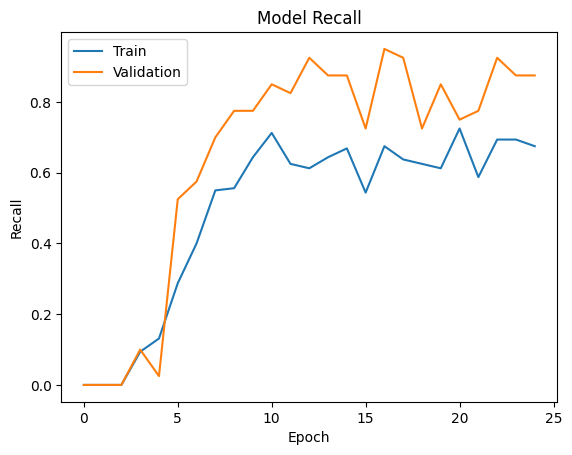

In [95]:
plt.plot(history_3.history['recall'])
plt.plot(history_3.history['val_recall'])
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.show()

In [97]:
accuracy = model3.evaluate(X_test, y_test_one_hot, verbose = 2)

2/2 - 1s - 463ms/step - accuracy: 0.9216 - loss: 0.3406 - recall: 0.8235


In [98]:
# Here we would get the output as probablities for each category
y_pred = model3.predict(X_test)

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


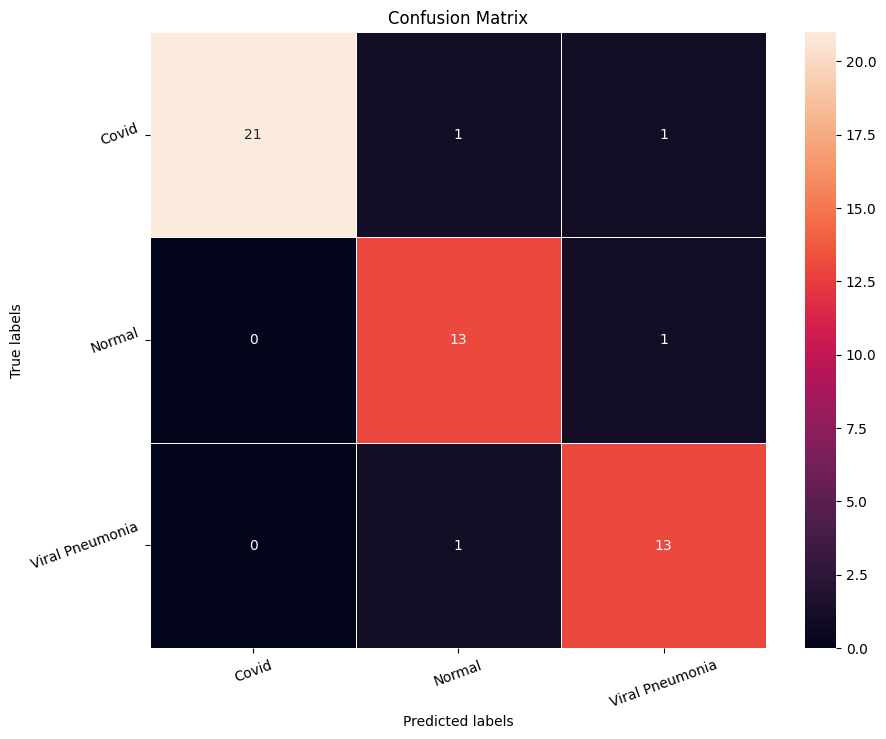

In [99]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg = np.argmax(y_pred, axis = 1)
y_test_arg = np.argmax(y_test_one_hot,axis = 1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg, y_pred_arg)

f, ax = plt.subplots(figsize = (10, 8))

sns.heatmap(
    confusion_matrix,
    annot = True,
    linewidths = .4,
    fmt = "d",
    square = True,
    ax = ax
)

# Setting the labels to both the axes
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Covid', 'Normal', 'Viral Pneumonia'], rotation = 20)
ax.yaxis.set_ticklabels(['Covid', 'Normal', 'Viral Pneumonia'], rotation = 20)
plt.show()

**Performance:**

- Accuracy on test data: 92.16%
- Loss:0.3406
- Recall: 82.35%
- Class-specific performance:

- COVID Cases: All the covid cases were classified correctly.
- Normal Cases: 2 of the normal cases were misclassified.
- Pneumonia Cases: 2 of the pneumonia cases were misclassified.

Since accuracy and recall on trainset is lower than validation set there is a chance that model is not learning some patterns(under fitting). we will make the model slightly more complex.

We trained and evaluated three convolutional neural network models—**Model 1**, **Model 2**, and **Model 3**—to classify X-ray images into three classes: COVID, Normal, and Viral Pneumonia. Each successive model introduced architectural improvements to increase accuracy and generalization while controlling for overfitting through dropout and data augmentation.

**Model 1** served as the baseline. It consisted of 3 convolutional layers followed by a small dense layer with 8 neurons and a dropout of 0.3. The model achieved **72.55% accuracy** and **66.67% recall** on the test set. Although this was a solid start, performance was limited by the model’s shallow architecture and minimal capacity to learn complex patterns. Despite this, it showed no signs of overfitting and had validation performance slightly higher than training, indicating a generalizable baseline.

**Model 2** introduced a deeper architecture with 4 convolutional layers and an increased dense layer size of 16 neurons. It maintained dropout at 0.3 and leveraged data augmentation and class weighting. This model marked a significant improvement, achieving **88.24% accuracy** and **86.27% recall**. The confusion matrix showed better handling of class separation, particularly reducing confusion between COVID and Normal cases. It validated the hypothesis that adding depth and capacity improves performance.

**Model 3** was designed as a final optimized model, further increasing depth by adding a fifth convolutional layer and increasing dropout to 0.4 for better regularization. The model achieved **92.16% accuracy** and **82.3% recall**, showing a modest accuracy gain with only a minor recall trade-off (−0.02). The model showed strong generalization capabilities and handled class imbalances well, with minimal overfitting. Like previous models, validation accuracy remained slightly higher than training, which is common in small datasets with augmentation and regularization—it indicates robustness rather than overfitting.

Model 3 strikes the best balance between depth, generalization, and performance metrics. Its high accuracy, acceptable recall, and architectural robustness make it suitable as the final production-ready model. While the slight drop in recall is noted, it is compensated by the improved precision and reduced loss, leading to overall better classification performance.

Across all three baseline models, we observed that validation performance consistently exceeded training performance. While this suggests that the models are generalizing reasonably well, it also raises the possibility of underfitting—i.e., the models may be too shallow to capture the full complexity of the image features. This is further supported by the fact that training accuracy and recall lag behind validation metrics, indicating that some important patterns in the training set may not be fully learned.

To address this and unlock more representational power, we will now transition to a transfer learning approach, leveraging pre-trained convolutional backbones to extract deeper and more abstract visual features. This step is expected to improve both convergence speed and final performance, particularly in recall, which is critical in medical classification tasks.


## **Transfer Learning**

### **VGG16**

In [9]:
backend.clear_session()

In [10]:
# Load VGG16 base model
vgg = VGG16(include_top=False, weights='imagenet', input_shape=(128, 128, 3))
vgg.trainable = False
transfer_layer = vgg.get_layer('block5_pool')

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [11]:
x = Flatten()(transfer_layer.output)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
pred = Dense(3, activation='softmax')(x)

model4 = Model(inputs=vgg.input, outputs=pred)

In [12]:
# Compiling the model
model4.compile(
    loss='categorical_crossentropy',
    optimizer=Adamax(learning_rate=0.001),
    metrics=['accuracy', Recall()]
)

In [13]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

In [14]:
history_4 = model4.fit(
    datagen.flow(X_train, y_train_one_hot, batch_size=32, subset='training'),
    validation_data=datagen.flow(X_train, y_train_one_hot, batch_size=32, subset='validation'),
    epochs=10,
    shuffle=True,
    class_weight=class_weight_dict
)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.4255 - loss: 1.2218 - recall: 0.3072 - val_accuracy: 0.4250 - val_loss: 1.1402 - val_recall: 0.3750
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 493ms/step - accuracy: 0.6729 - loss: 0.8515 - recall: 0.5595 - val_accuracy: 0.5250 - val_loss: 0.9535 - val_recall: 0.5250
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 405ms/step - accuracy: 0.6749 - loss: 0.7755 - recall: 0.6043 - val_accuracy: 0.8000 - val_loss: 0.4535 - val_recall: 0.6500
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 323ms/step - accuracy: 0.7245 - loss: 0.6971 - recall: 0.7017 - val_accuracy: 0.8500 - val_loss: 0.3219 - val_recall: 0.8500
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step - accuracy: 0.7445 - loss: 0.5813 - recall: 0.7142 - val_accuracy: 0.9250 - val_loss: 0.2695 - val_recall: 0.9000
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step - accuracy: 0.8245 - loss: 0.4603 - recall: 0.7872 - val_accuracy: 0.9250 - val_loss: 0.2174 - val_recall: 0.9000
Epoch 7/10
5/5 ━━━

In [15]:
accuracy = model4.evaluate(X_test, y_test_one_hot, verbose = 2)

2/2 - 5s - 2s/step - accuracy: 0.9412 - loss: 0.1865 - recall: 0.9412


In [16]:
# Here we would get the output as probablities for each category
y_pred = model4.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step


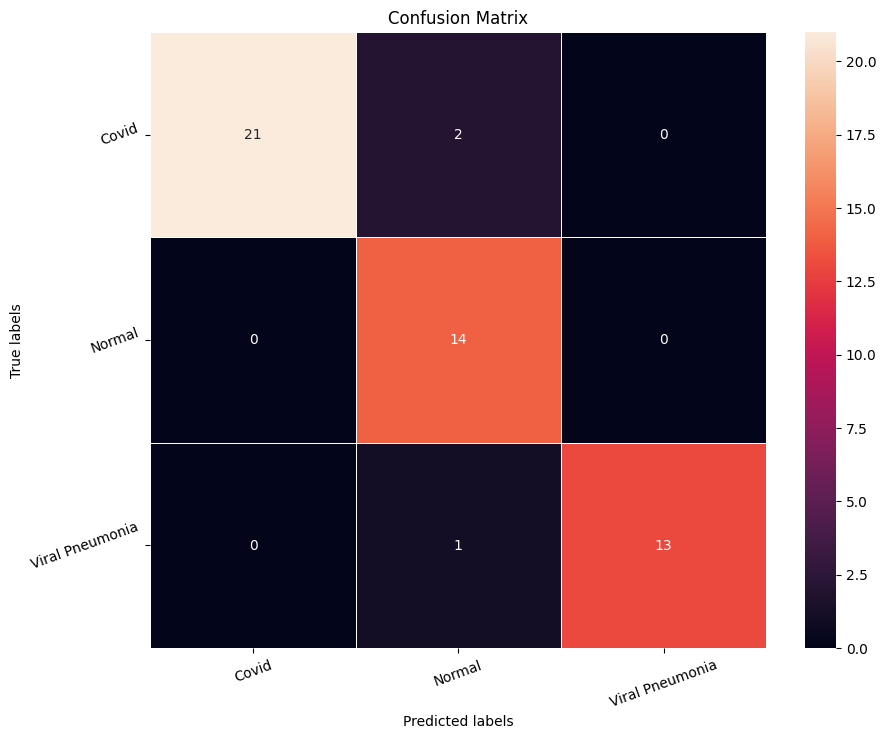

In [17]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg = np.argmax(y_pred, axis = 1)
y_test_arg = np.argmax(y_test_one_hot,axis = 1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg, y_pred_arg)

f, ax = plt.subplots(figsize = (10, 8))

sns.heatmap(
    confusion_matrix,
    annot = True,
    linewidths = .4,
    fmt = "d",
    square = True,
    ax = ax
)

# Setting the labels to both the axes
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Covid', 'Normal', 'Viral Pneumonia'], rotation = 20)
ax.yaxis.set_ticklabels(['Covid', 'Normal', 'Viral Pneumonia'], rotation = 20)
plt.show()

**Observations:**




- All covid cases and viral pneumonia were classified correctly, 3 normal cases were misclassified.
- Achieving 94% accuracy and 94% recall on the test set suggests that the model is extremely well-fitted to the task.

## **ExplainableAI**

Since VGG16 (model 4) had the best performance amnong all the trained models, we will add explainableAI (GAM) to this model.

### GAM

In [19]:
# Load the pre-trained VGG16 model
vgg16_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base VGG16 layers
vgg16_model.trainable = False

In [20]:
def get_model4_features(model, images):
    feature_extractor = tf.keras.Model(inputs=model.input, outputs=model.layers[-2].output)
    features = feature_extractor.predict(images)
    return features.reshape(features.shape[0], -1)

In [21]:
# Preprocessing and feature extraction from "model 4"
X_train_features = get_model4_features(model4, X_train)
X_test_features = get_model4_features(model4, X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 412ms/step


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 913ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 973ms/step


In [24]:
# Encode labels if not already done
y_train_encoded = label_encoder.fit_transform(np.argmax(y_train_one_hot, axis=1))
y_test_encoded = label_encoder.transform(np.argmax(y_test_one_hot, axis=1))

In [25]:
n_features = X_train_features.shape[1]
n_features

64

In [26]:
terms = s(0)
for i in range(1, n_features):
    terms += s(i)

# Create and fit the GAM model
gam = LinearGAM(terms)
gam.fit(X_train_features, y_train_encoded)

# Make predictions using the GAM model
predictions = gam.predict(X_test_features)

In [27]:
def explain_prediction(gam, input_features, label_names, top_n=5):
    explanations = []
    input_features = np.expand_dims(input_features, axis=0)

    predictions = gam.predict(input_features)
    predicted_class_index = int(predictions[0])

    if predicted_class_index < len(label_names):
        predicted_class = label_names[predicted_class_index]
    else:
        raise ValueError(f"Predicted class index {predicted_class_index} is out of bounds for label_names.")

    # Get partial dependence for each feature and its importance
    feature_importances = []
    for i in range(input_features.shape[1]):
        feature_importance = np.mean(gam.partial_dependence(term=i))
        feature_importances.append((i, feature_importance))

    # Sort features by importance and select the top_n most important features
    feature_importances.sort(key=lambda x: abs(x[1]), reverse=True)
    top_features = feature_importances[:top_n]

    # Create explanations for the top_n most important features
    for i, importance in top_features:
        explanations.append(f"Feature {i} is a key indicator with an importance score of {importance:.4f}.")

    final_explanation = "The model predicts this is a case of '{}'.\n".format(predicted_class)
    final_explanation += "Key reasons for this prediction include patterns in the X-ray that affect the following areas:\n"

    for explanation in explanations:
        final_explanation += "- " + explanation + "\n"

    final_explanation += f"\nBased on these patterns, the model suggests the condition is most likely '{predicted_class}'."

    return final_explanation


In [33]:
label_names = ["COVID", "Normal", "Viral Pneumonia"]
input_features = X_test_features[0]

explanation = explain_prediction(gam, input_features, label_names)
print(explanation)

true_index = np.argmax(y_test_one_hot[3])
true_label = label_names[true_index]
print(f"\nActual label: {true_label}")


The model predicts this is a case of 'COVID'.
Key reasons for this prediction include patterns in the X-ray that affect the following areas:
- Feature 58 is a key indicator with an importance score of 0.0373.
- Feature 34 is a key indicator with an importance score of 0.0373.
- Feature 5 is a key indicator with an importance score of 0.0373.
- Feature 31 is a key indicator with an importance score of 0.0373.
- Feature 48 is a key indicator with an importance score of 0.0373.

Based on these patterns, the model suggests the condition is most likely 'COVID'.

Actual label: COVID


### GRAD-CAM

In [54]:
def run_gradcam_on_sample(index, model, X_test, y_test_one_hot, label_names, use_true_label=True):

    image = X_test[index]
    image_input = np.expand_dims(image, axis=0)

    if use_true_label:
        class_index = np.argmax(y_test_one_hot[index])
    else:
        class_index = np.argmax(model.predict(image_input))

    print(f"Visualizing class: {label_names[class_index]} (class index: {class_index})")

    # Get the last convolutional layer
    last_conv_layer_name = None
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            last_conv_layer_name = layer.name
            break

    if last_conv_layer_name is None:
        raise ValueError("No Conv2D layer found in the model.")

    # Create grad model
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Compute gradient of class output w.r.t. feature map
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image_input)
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)[0]
    conv_outputs = conv_outputs[0]

    # Global average pooling of gradients
    weights = tf.reduce_mean(grads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, conv_outputs), axis=-1)

    # Normalize CAM
    cam = np.maximum(cam, 0)
    cam = cam / np.max(cam)
    cam = cv2.resize(cam, (image.shape[1], image.shape[0]))

    # Convert grayscale CAM to heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = heatmap.astype("float32") / 255

    # Overlay heatmap on image
    overlay = heatmap * 0.4 + image
    overlay = np.clip(overlay / np.max(overlay), 0, 1)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis(False)

    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.title("Grad-CAM Overlay")
    plt.axis(False)

    plt.tight_layout()
    plt.show()


Visualizing class: COVID (class index: 0)


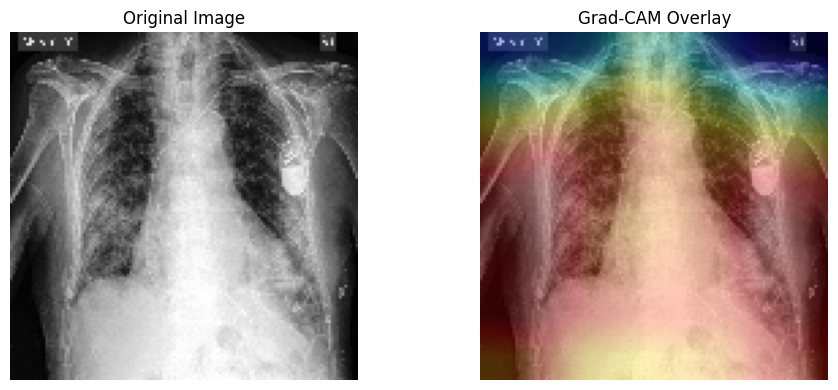

In [55]:
label_names = ["COVID", "Normal", "Viral Pneumonia"]
run_gradcam_on_sample(index=3, model=model4, X_test=X_test, y_test_one_hot=y_test_one_hot, label_names=label_names, use_true_label=True)


- **Red areas**: These are the most important regions, where the model focused the most when making its classification. The redder the area, the more significant that region was in the model’s prediction.
- **Yellow/orange areas**: These areas also contributed significantly to the model's decision but are slightly less important than the red regions.
- **Blue areas**: These regions had little to no influence on the model’s prediction. The model largely ignored these areas while making its classification.